# Семинар 7

### Решающие деревья

<img src='tree_example.png'>

Сами по себе решающие деревья используются в машинном обучении относительно редко, однако очень распространены методы, основанные на их композиции - ансамблях (Random Forest, XGBoost, LightGBM).

##### Плюсы:

- интерпретируемость
- способность выделить самые важные признаки
- отсутствие потребности в серьезной предобработке данных

##### Минусы:

- склонность к переобучению
- неустойчивость - небольшие изменения в данных могут привести к сильному изменению в структуре дерева
- эвристичность обучения - как оптимизировать?

#####  Линейная модель vs "деревянная" модель (основанная на решающих деревьях):

- когда данные хорошо линейно разделимы, линейная модель лучше

- когда данные плохо линейно разделимы (много сложных нелинейных зависимостей в данных), "деревянная" модель лучше

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (15, 6)

### Переобучение

In [3]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

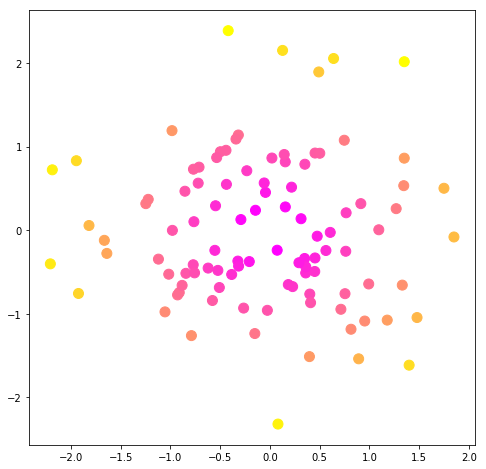

In [4]:
np.random.seed(13)
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5 # 
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')

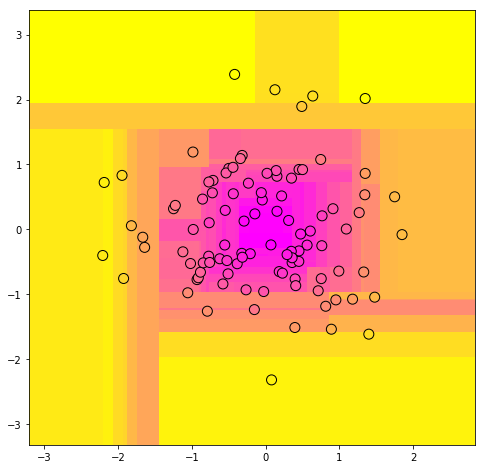

In [5]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(random_state=13)
clf.fit(data_x, data_y)

xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring', edgecolor='k')
plt.show()

Посмотрим, как будет выглядеть разделение плоскости в зависимости от максимальной глубины дерева и минимального числа объектов в листе.

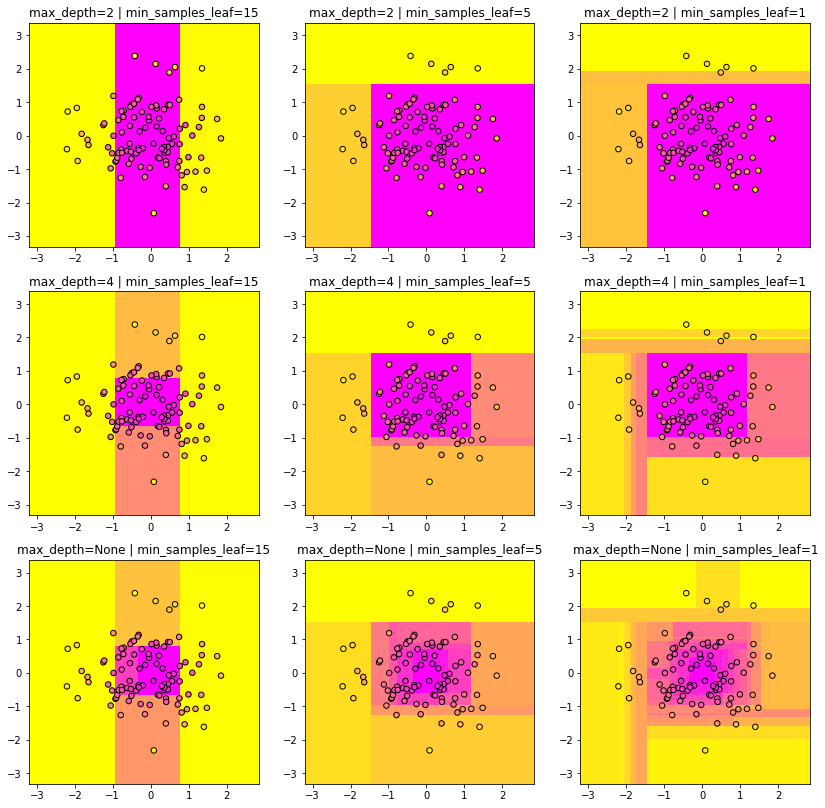

In [6]:
plt.figure(figsize=(14, 14))
for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=13)
        clf.fit(data_x, data_y)
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='spring')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='spring', edgecolor='k')
        plt.title('max_depth=' + str(max_depth) + ' | min_samples_leaf=' + str(min_samples_leaf))

### Неустойчивость

Посмотрим, как будет меняться структура дерева, если брать для обучения разные 90%-ые подвыборки исходной выборки.

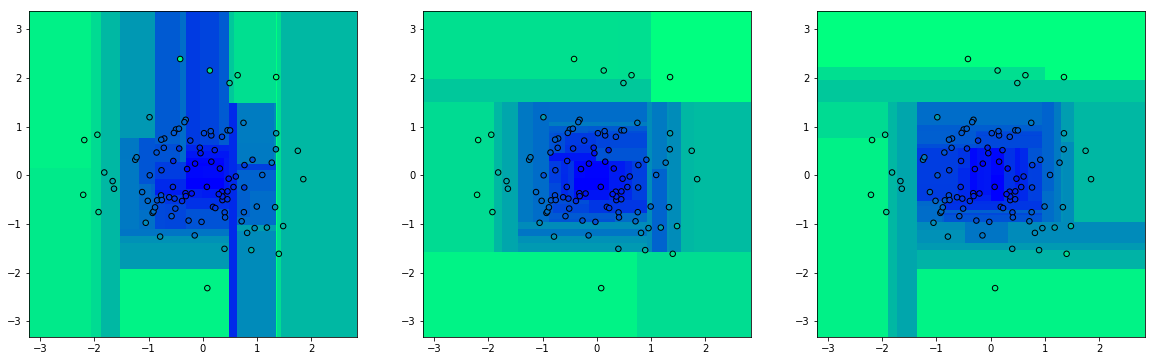

In [7]:
plt.figure(figsize=(20, 6))
for i in range(3):
    clf = DecisionTreeRegressor(random_state=13)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter', edgecolor='k')

In [8]:
data_x.shape[0]

100

### Практика

In [9]:
boston = load_boston()

In [10]:
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [11]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [12]:
boston['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [13]:
boston['data'].shape

(506, 13)

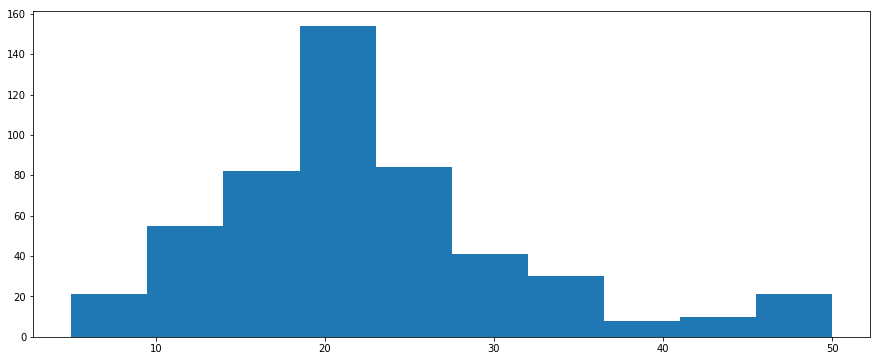

In [14]:
plt.hist(boston['target'])
plt.show()

In [15]:
X = pd.DataFrame(boston['data'], columns=boston['feature_names'])
X['target'] = boston['target']

In [16]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


$R_m$ - множество объектов в разбиваемой вершине, $i$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения.

Качество:

$$
Q(R_m, i, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r)
$$

$R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

$H(R)$ - критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

_Вопрос. Что можно использовать в качестве критерия информативности для регрессии?_

_Реализуйте подсчет качества разбиения._

In [18]:
def H(R):
    y_mean = R['target'].mean()
    return np.mean((R['target'] - y_mean) ** 2)

def split_node(R_m, feature, t):
    mask = R_m.loc[:, feature] < t
    return R_m[mask], R_m[~mask]

def quality(R_m, feature, t):
    R_left, R_right = split_node(R_m, feature, t)
    return H(R_m) - (R_left.shape[0] / R_m.shape[0]) * H(R_left)\
                  - (R_right.shape[0] / R_m.shape[0]) * H(R_right) 

_Переберите все возможные разбиения выборки по одному из признаков и постройте график качества разбиения в зависимости от значения порога._

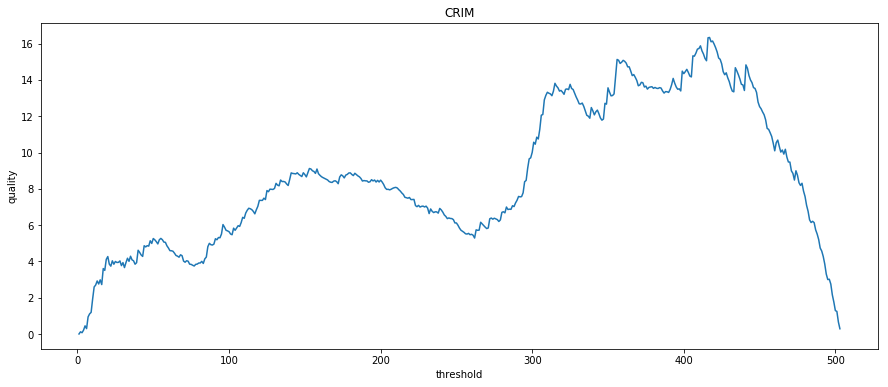

In [20]:
feature = 'CRIM'
Q_array = []
for t in np.unique(X[feature]):
    Q_array.append(quality(X, feature, t))
plt.plot(Q_array)
plt.title(feature)
plt.xlabel('threshold')
plt.ylabel('quality')
plt.show()

### Многоклассовая классификация

In [22]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier 

In [23]:
iris = load_iris()
X = pd.DataFrame(iris['data'], columns=iris['feature_names'])
y = iris['target']

In [24]:
X.shape, y.shape

((150, 4), (150,))

In [25]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((112, 4), (38, 4), (112,), (38,))

Понятно, что accuracy можно использовать как метрику качества не только в задаче бинарной классификации, но и в задаче многоклассовой классификации. Но что делать с precision, recall, f1? Можно сделать предсказание и воспользоваться какой-то из стратегий ниже.

#### Микро-усреднение (micro-average)

1) Считаются характеристики TP, FP, TN, FN для каждого класса.

2) Характеристики TP, FP, TN, FN усредняются по всем классам.

3) Метрики считаются по усредненным характеристикам.

Например, в случае precision:

$$
Precision = \frac{\sum\limits_{k}TP_k}{\sum\limits_{k}TP_k + \sum\limits_{k}FP_k},
$$

где $TP_k$ и $FP_k$ - TP и FP для класса $k$ соответственно.

#### Макро-усреднение (macro-average)

1) Считаются характеристики TP, FP, TN, FN для каждого класса.

2) Считаются метрики для каждого класса.

3) Итоговые метрики равны средним посчитанных метрик.

В данном случае precision считается так:

$$
Precision = \frac{\sum\limits_{k}Precision_k}{K},
$$

где $Precision_k$ - значение precision для класса $k$, а $K$ - общее число классов.

In [27]:
def get_scores(estimator, X=X_test, y=y_test):
    y_pred = estimator.predict(X)

    accuracy = accuracy_score(y_test, y_pred)
    precision_micro = precision_score(y_test, y_pred, average='micro')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    columns = ['accuracy', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro']
    results = pd.DataFrame(
        [accuracy, precision_micro, precision_macro, recall_micro, recall_macro, f1_micro, f1_macro],
        index=columns
    ).T
    conf_matrix = pd.DataFrame(
        conf_matrix,
        columns=['Predicted: 0', 'Predicted: 1', 'Predicted: 2'],
        index=['Actual: 0', 'Actual: 1', 'Actual: 2']
    )
    
    return results, conf_matrix

In [28]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)
dt_res, dt_conf = get_scores(dt)
dt_res

,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,0.973684,0.973684,0.969697,0.973684,0.979167,0.973684,0.973374


In [29]:
dt_conf

,Predicted: 0,Predicted: 1,Predicted: 2
Actual: 0,12,0,0
Actual: 1,0,10,0
Actual: 2,0,1,15


In [30]:
lr = LogisticRegression(C=1)
lr.fit(X_train, y_train)
lr_res, lr_conf = get_scores(lr)
lr_res

/Users/vkokhtev/programs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vkokhtev/programs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,0.947368,0.947368,0.962963,0.947368,0.933333,0.947368,0.943355


In [31]:
lr_conf

,Predicted: 0,Predicted: 1,Predicted: 2
Actual: 0,12,0,0
Actual: 1,0,8,2
Actual: 2,0,0,16


Некоторые классификаторы (например, логистическая регрессия, решающее дерево) могут быть использованы не только для задач бинарной классификации, но и для задач многоклассовой классификации. В общем же случае для решения задачи многоклассовой классификации можно свести ее к задачам бинарной разными методами.

#### One-vs-All

Разбиваем задачу многоклассовой классификации с $K$ классами на $K$ задач бинарной классификации, где обучаем классификаторы, которые предсказывают ответы вида "принадлежит классу $k$ / не принадлежит классу $k$".

k-я задача:

- $X = \left(x_i, [y_i = k] - [y_i \neq k]\right)_{i=1}^\ell$

- классификатор $a_k(x) = \operatorname{sign}\langle w_k, x\rangle$

В качестве предсказания выбираем класс, соответствующий наиболее "уверенному" в своем классе классификатору:

$$
a(x) = \arg\max_{k\in\{1, \ldots, K\}}\langle w_k, x\rangle
$$

#### One-vs-One

Разбиваем задачу многоклассовой классификации с $K$ классами на $\frac{K(K - 1)}{2}$ задач бинарной классификации, где для каждой пары классов $(k, k')$ обучаем классификатор, который предсказывает ответы вида "принадлежит классу $k$ / принадлежит классу $k'$".

Задача для $(k, k')$:

- $X = \left(x_i, [y_i = k] - [y_i \neq k']\right)_{i=1}^\ell$

- классификатор $a_{k, k'}(x) = \operatorname{sign}\langle w_{k, k'}, x\rangle$

В качестве предсказания выбираем класс, который чаще всего выбирался бинарными классификаторами:

$$
a(x) = \arg\max_{k\in\{1, \ldots, K\}}\left|\{k':a_{k, k'}(x) = 1\}\right|
$$

In [32]:
ovr = OneVsRestClassifier(lr)
ovr.fit(X_train, y_train)
ovr_res, ovr_conf = get_scores(ovr)
ovr_res

/Users/vkokhtev/programs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vkokhtev/programs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vkokhtev/programs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,0.947368,0.947368,0.962963,0.947368,0.933333,0.947368,0.943355


In [33]:
ovr_conf

,Predicted: 0,Predicted: 1,Predicted: 2
Actual: 0,12,0,0
Actual: 1,0,8,2
Actual: 2,0,0,16


In [34]:
ovr.estimators_

[LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False)]

In [35]:
ovo = OneVsOneClassifier(lr)
ovo.fit(X_train, y_train)
ovo_res, ovo_conf = get_scores(ovo)
ovo_res

/Users/vkokhtev/programs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vkokhtev/programs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vkokhtev/programs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,0.973684,0.973684,0.980392,0.973684,0.966667,0.973684,0.972355


In [36]:
ovo_conf

,Predicted: 0,Predicted: 1,Predicted: 2
Actual: 0,12,0,0
Actual: 1,0,9,1
Actual: 2,0,0,16


In [37]:
ovo.estimators_

(LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False))